# PCA, SVM and RF with movie posters 

### Load data
- select 100 movies from the training set 
- select 50 movies from the testing set

### Preprocess data
- resize to (741,500), min size of the images
- grayscale the images

### Fit PCA
- Perform PCA on training set 
- retain number of components which explain 90% of variance
- project the testing and training data onto top principal components

### Fit models and predict on test set
- fit one versus rest classifier with SVM and RBF
- evaluate accuracy 

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import os
from pylab import imread, imshow
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from scipy.misc import imresize
import matplotlib.image as mpimg
import pandas as pd

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA, IncrementalPCA

from sklearn.metrics import hamming_loss
from sklearn.ensemble import RandomForestClassifier

In [3]:
############# Read in data ################

train = pd.read_csv('../data/train_data_with_sampling.csv')
test = pd.read_csv('../data/test_data.csv')

############# Convert to test and train set ################

X_train_ids = train[['tmdb_id']].values
y_train = train[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()
X_test_ids = test[['tmdb_id']].values
y_test = test[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()

############# Function to convert color to grayscale ################

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

############# Read in posters for training set ################

def load_posters_from_ids(id_array, n, y):
    start = np.random.choice(range(len(id_array)-n))
    end = start + n
    posters = []
    ids = []
    errors = 0
    for poster in id_array[start:end]:
        img = mpimg.imread('../posters/' + str(int(poster[0])) + '.jpg') 
        # grayscale image 
        gray = rgb2gray(img)
        try:
            scaled = imresize(gray, (741,500))
            posters.append(np.asarray(scaled))
            ids.append(poster)
        except ValueError:
            errors +=1
            continue
    posters_array = np.asarray(posters)
    X = np.array(posters_array)
    
    Y = y[:n]
    print 'posters shape: ', X.shape
    print 'errors: ', errors
    return X, Y

In [4]:
# These are how we measure error - Haming Loss, % exact matches and % at-least-one match
from sklearn.metrics import hamming_loss

def error_measures(ypred, ytest):
    ypred = np.array(ypred)
    ytest = np.array(ytest)
    
    # Hamming loss
    h_loss = hamming_loss(ytest, ypred)

    # Percent exact matches
    y_pred_str = np.array([str(yi) for yi in ypred])
    y_test_str = np.array([str(yi) for yi in ytest])
    percent_exact = np.sum(y_pred_str == y_test_str) * 1. / ytest.shape[0]
    
    # Percent at least one match (at least one of the genres are both 1)
    atleastone_count = 0
    for ind in range(len(ypred)):
        yi_pred = ypred[ind]
        yi_test = ytest[ind]
        for i in range(len(yi_pred)):
            if yi_pred[i] == 1 and yi_test[i] == 1:
                atleastone_count += 1
                break
    percent_atleastone = atleastone_count * 1. / ytest.shape[0]
    
    return h_loss, percent_exact, percent_atleastone

In [5]:
X_train_unshaped, Y_train = load_posters_from_ids(X_train_ids, 500, y_train)
X_test_unshaped, Y_test = load_posters_from_ids(X_test_ids, 50, y_test)

X_train = X_train_unshaped.reshape((X_train_unshaped.shape[0], -1))
X_test = X_test_unshaped.reshape((X_test_unshaped.shape[0], -1))

posters shape:  (500, 741, 500)
errors:  0
posters shape:  (50, 741, 500)
errors:  0


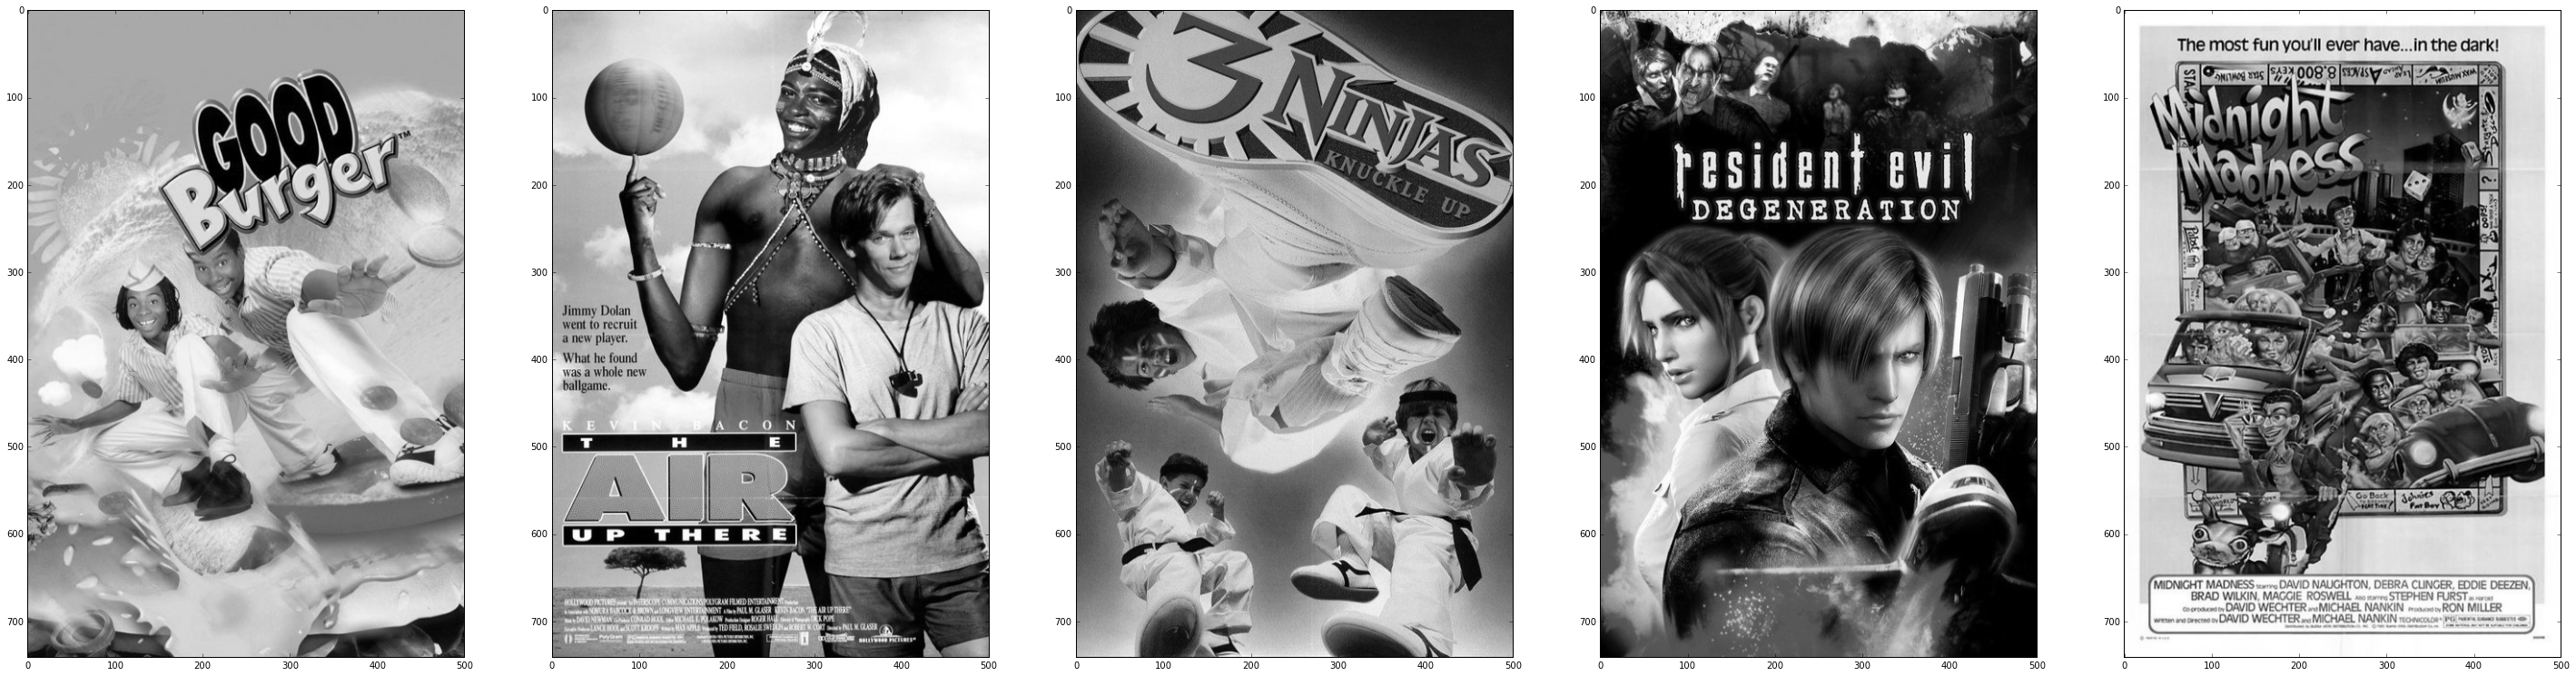

In [6]:
############# Visualise first 5 images of training set ################

plt.figure(figsize=(50,50))
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(X_train_unshaped[i], cmap = plt.get_cmap('gray'))

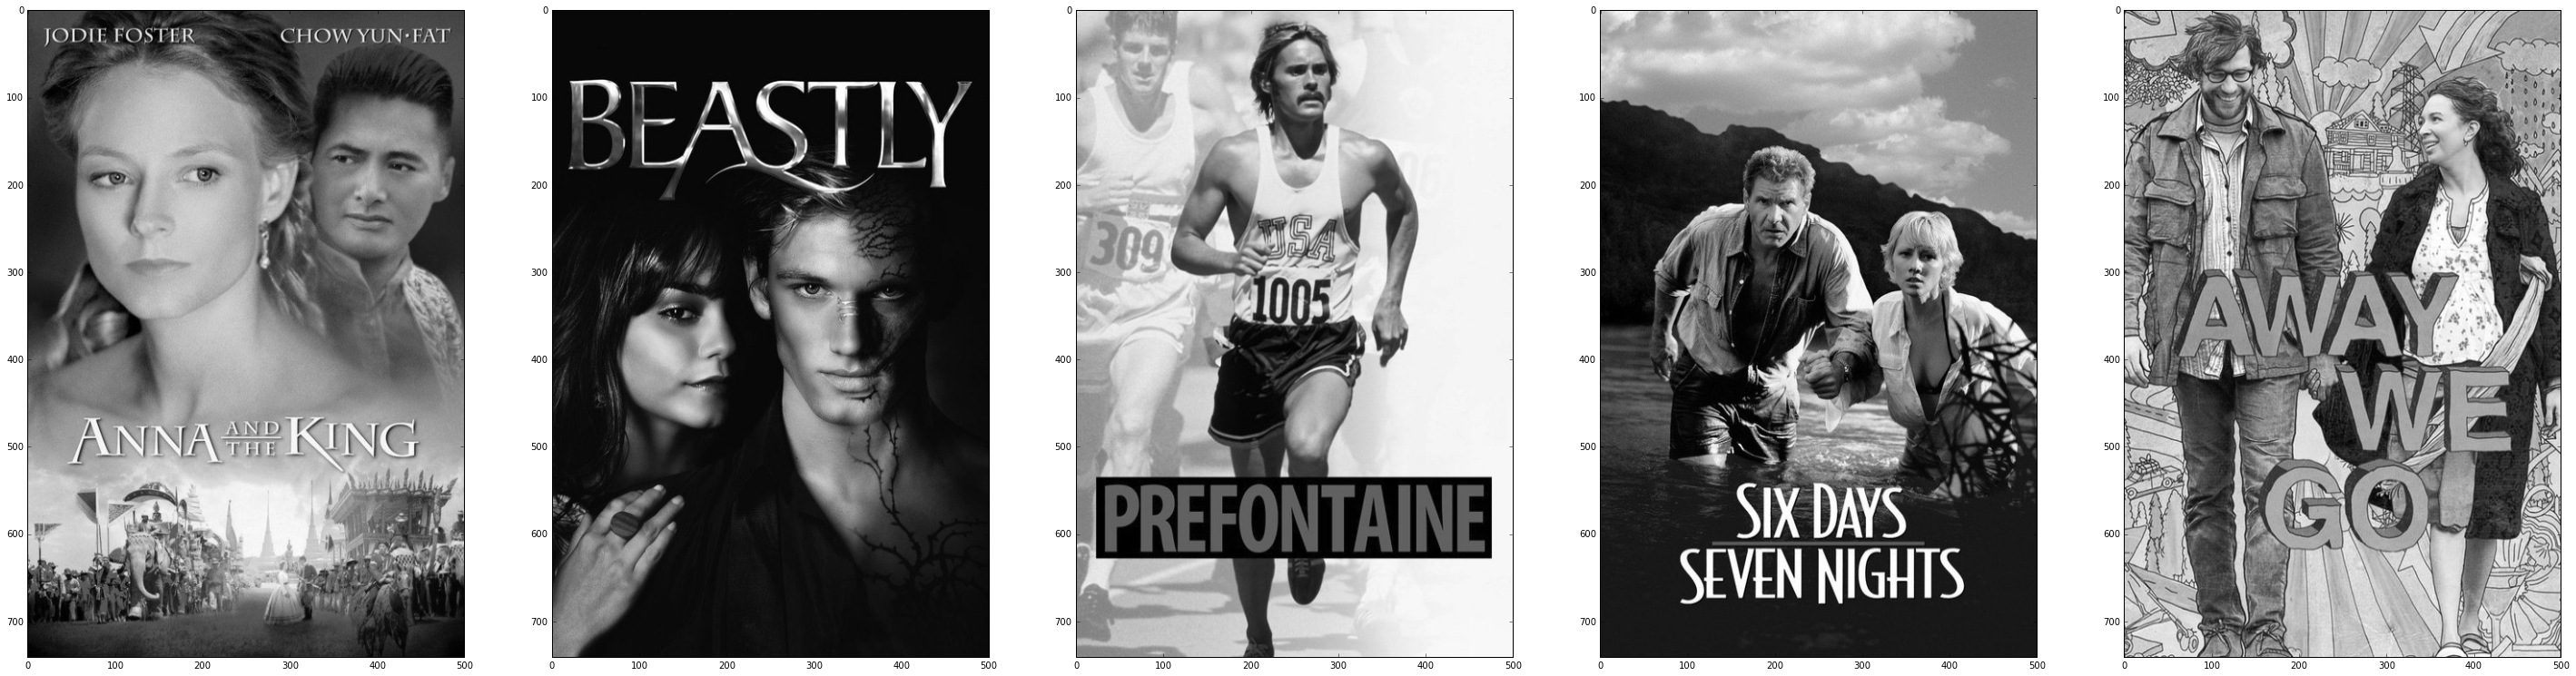

In [7]:
############# Visualise first 5 images of testing set ################

plt.figure(figsize=(50,50))
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(X_test_unshaped[i], cmap = plt.get_cmap('gray'))

In [ ]:
X_train.shape

(500, 370500)

In [ ]:
################### PCA on training set #####################################

# fit PCA model
posters_pca = PCA(n_components=50) #n_components is initialised to the minimum of n_components, n_features
pca = posters_pca.fit(X_train)

In [ ]:
# look at cumulative variance plot 

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.plot(cumulative_variance) # explained variance ration
plt.xlabel('number of components')
plt.ylabel('proportion of variance explained')
plt.title('explained variance ratio')

# # number of components to explain 90% of variance
# n90 = np.where(cumulative_variance>0.9)[0][0]
# print 'num components to explain 90% of variance ', n90

Retain the n_components which cumulatively explain 90% of the variance

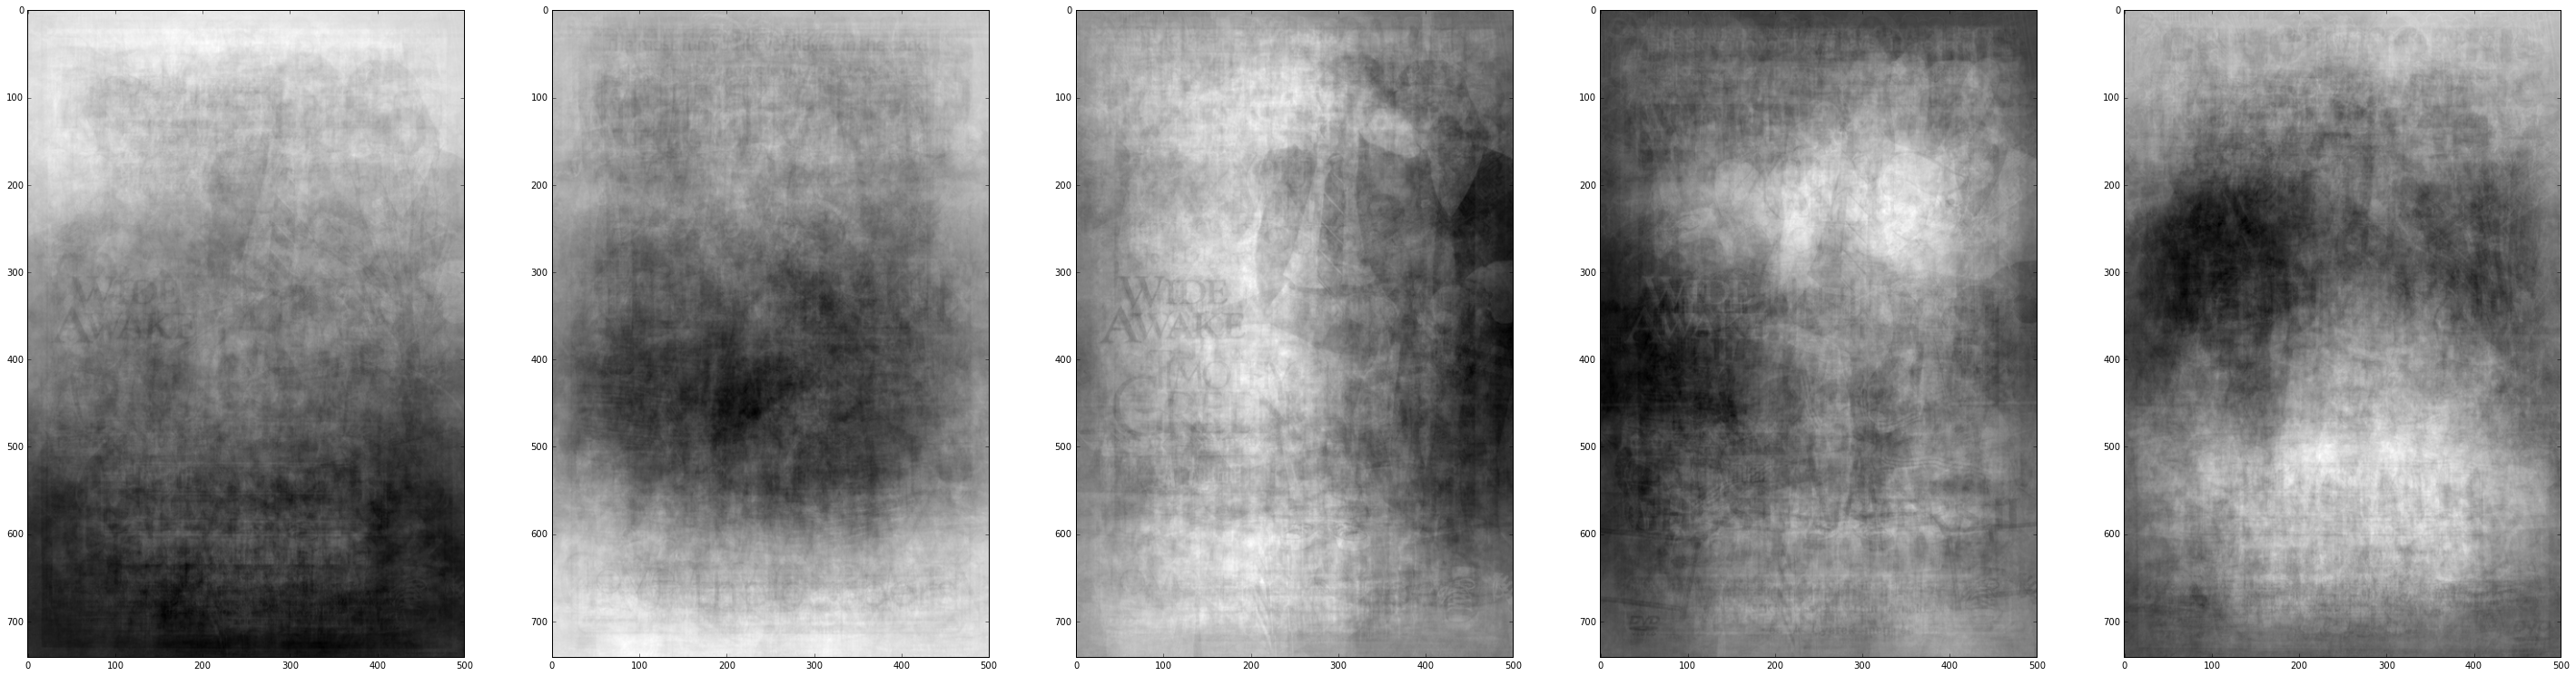

In [24]:
############## TOP 5 principal components ###########################

plt.figure(figsize=(50,50))
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(pca.components_[i, :].reshape((741,500)), cmap = plt.get_cmap('gray'))

In [11]:
################### REFIT PCA on training set and set num_components #####################################

# fit PCA model
posters_pca = PCA(n_components=10) 
pca = posters_pca.fit(X_train)


KeyboardInterrupt: 

In [ ]:
pca.components_.shape

In [25]:
###### Project testing and training data onto top n components

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

############## Fit SVM model ######################
Y_pred = OneVsRestClassifier(SVC(kernel='rbf')).fit(X_train_pca, Y_train).predict(X_test_pca)

h_loss, percent_exact, percent_atleastone = error_measures(Y_pred, Y_test)

print 'Untuned Radial SVM\n=====================\n'
print 'hamming: ', h_loss
print 'percent_exact: ', percent_exact 
print 'percent_atleastone: ', percent_atleastone


//anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))


Untuned Radial SVM

hamming:  0.14
percent_exact:  0.3
percent_atleastone:  1.0


In [26]:
############## Fit RF model ######################

clf = RandomForestClassifier(n_estimators=25, random_state=0)

Y_pred = OneVsRestClassifier(clf).fit(X_train_pca, Y_train).predict(X_test_pca)

h_loss, percent_exact, percent_atleastone = error_measures(Y_pred, Y_test)

print 'Untuned Random Forest \n=====================\n'
print 'hamming: ', h_loss
print 'percent_exact: ', percent_exact 
print 'percent_atleastone: ', percent_atleastone


Untuned Random Forest 

hamming:  0.154285714286
percent_exact:  0.24
percent_atleastone:  1.0
